# Homework 3

## Group 2: Hayden Smotherman, Chris Suberlak, Winnie Wang

## Assignment
Group 2 uses the gaussian profile (with the same parameters as in the lecture):

1) Can you tell which model is correct using global likelihood computation?

2) Can you tell which model is correct using BIC?

3) What happens when you increase the number of data points by a factor of 2 (using BIC)?

4) What happens when you decrease the number of data points by a factor of 2 (using BIC)?

In [16]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.special import gamma
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from sklearn.neighbors import BallTree
from astroML.plotting import hist
from astroML.plotting.mcmc import plot_mcmc
from astroML.plotting import setup_text_plots
import pymc
setup_text_plots(fontsize=8, usetex=True)

%matplotlib inline

### This cell defines model functions and helper functions

In [41]:
### Modeled after AstroML book figure 10.25

# Define the function from which to generate the data
def GaussAndBkgd(t, b0, A, sigW, T):
    """Gaussian profile + flat background model"""
    y = np.empty(t.shape)
    y.fill(b0)
    y += A * np.exp(-(t - T)**2/2/sigW**2)
    return y

# Define the exponential burst profile
def burst(t, b0, A, alpha, T):
    """Burst model"""
    y = np.empty(t.shape)
    y.fill(b0)
    mask = (t >= T)
    y[mask] += A * np.exp(-alpha * (t[mask] - T))
    return y

# Define a function that calculates and prints the BIC for each model
def Print_BIC(Gauss_ChiSq,Exp_ChiSq,N):
    print('\n================ Model BIC Information ===============')
    print('For N=%i Data Points:' %N)
    print('BIC for Gaussian Profile: %.1f' %(Gauss_ChiSq+4*np.log(N)))
    print('BIC for Exponential Profile: %.1f' %(Exp_ChiSq+4*np.log(N)))
    print('=======================================================')

# The following functions are from http://www.astroml.org/book_figures/chapter5/fig_model_comparison_mcmc.html

# This one calculates the log of the pdf and is used for calculating the bayes factor
def get_logp(S, model):
    """compute log(p) given a pyMC model"""
    M = pymc.MAP(model)
    traces = np.array([S.trace(s)[:] for s in S.stochastics])
    logp = np.zeros(traces.shape[1])
    for i in range(len(logp)):
        logp[i] = -M.func(traces[:, i])
    return logp

# This function estimates the log of evidence given an MCMC chain.
# This is used to calculate the odds ratio between two models
def estimate_log_evidence(traces, logp, r=0.02, return_list=False):
    """Estimate the log of the evidence, 
     using the local density of points. 
     The code is borrowed from the AstroML source
     code of Fig.5.24,  which in turn is based on 
     eq. 5.127 in Ivezic+2014
     """
    D, N = traces.shape

    # compute volume of a D-dimensional sphere of radius r
    Vr = np.pi ** (0.5 * D) / gamma(0.5 * D + 1) * (r ** D)

    # use neighbor count within r as a density estimator
    bt = BallTree(traces.T)
    count = bt.query_radius(traces.T, r=r, count_only=True)

    logE= logp + np.log(N) + np.log(Vr) - np.log(count)

    if return_list:
        return logE
    else:
        p25, p50, p75 = np.percentile(logE, [25, 50, 75])
        return p50, 0.7413 * (p75 - p25)


**Explanation : why the above estimation of the evidence works.**
   
We choose between two models M1 and M2 by sampling the posterior space with the MCMC method. The traces returned by MCMC provide an optimal sampling of the posterior space for parameters **$\theta$** (in our case, each model is parametrized with a set of four parameters :  { $b_{0}$, $A$, $T$, $\sigma$} for Gaussian model M1, and { $b_{0}$, $A$, $T$, $\alpha$} for Exponential decay model M2.  As eqs. 5.124-5.127 in Ivezic+2014 show, the Bayesian evidence  can be estimated by 

$ \mathrm{evidence} \equiv  L(M) = \frac{N p(\theta)}{\rho(\theta)}$.

Taking the logs : 

$\log(L) = \log(N p(\theta) / \rho(\theta) ) = \log(N p ) - \log(\rho) $

Now $\rho = \mathrm{counts} / \mathrm{volume}$ , both of which can be estimated using the BallTree algorithm that counts the number of samples in the hypersphere of a given volume. The radius is problem-dependent, but in this case we deemed $r=0.02$ to be sufficient. Thus : 

$\log(L) = \log(N) + \log(p) - \log(\mathrm{counts}) + \log(\mathrm{volume})$.

Other ways to estimate the posterior density in the multidimensional parameter space include kernel density estimation methods ( see Ivezic+2014, Sec. 6.1.1). There is more literature  on the problem of estimating the density of the posterior sampled with the MCMC method - see [Morey+2011](https://www.sciencedirect.com/science/article/pii/S0022249611000666), [Sharma+2017](https://arxiv.org/pdf/1706.01629.pdf), [Weinberg, M.D. 2010](https://scholarworks.umass.edu/cgi/viewcontent.cgi?article=1107&context=astro_faculty_pubs). 

### This cell defines the main model comparison, which does the MCMC chains, and the plotting function

In [62]:
def Run_Gaussian_Exponential_Comparison(N,b0_true=10,A_true=3.0,sigma_true=3.0,T_true=40):
    ''' 
    This function runs the model comparizon between a Gaussian Profile and an Exponential Profile.
    The Data is generated from a Gaussian Profile with N data points
    
    INPUT:  N                                       <- Number of Data Points
            b0_True, A_true, sigma_true, T_true     <- OPTIONAL: True values of the distribution from which data is generated
    OUTPUT: t_obs, y_obs, err_y                     <- Observed Randomly Generated Time, Flux and Flux Error values
            Gauss_Trace, Gauss_Fit, Gauss_BF        <- MCMC Trace, Best-Fit Parameters for Gaussian Model, and Bayes Factor
            Exp_Trace, Exp_Fit, Exp_BF              <- MCMC Trace, Best-Fit Parameters for Exponential Model, and Bayes Factor
    '''
    # Set a fixed random seed
    np.random.seed(42)
    
    #========================================================================================
    #                            Generate N Data Points
    #========================================================================================    

    err0_y = 0.5

    # Add noise and calculate the "observed" flux values
    t_obs = 100 * np.random.random(N)
    y_true = GaussAndBkgd(t_obs, b0_true, A_true, sigma_true, T_true)
    err_y = 0.5*np.sqrt(y_true/10) +np.random.uniform(0, 2*err0_y)
    y_obs = np.random.normal(y_true, err_y) # Observed flux values
    
    
    #========================================================================================
    #                            Run Gaussian MCMC Chain
    #========================================================================================
    
    # Set up MCMC sampling for Gaussian MCMC parameters
    b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
    A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
    T = pymc.Uniform('T', 0, 100, value=100 * np.random.random())
    log_sigma = pymc.Uniform('log_sigma', -2, 2, value=0.1)


    # uniform prior on log(alpha)
    @pymc.deterministic
    def sigma(log_sigma=log_sigma):
        return np.exp(log_sigma)


    @pymc.deterministic
    def y_model(t=t_obs, b0=b0, A=A, sigma=sigma, T=T):
        return GaussAndBkgd(t, b0, A, sigma, T)

    y = pymc.Normal('y', mu=y_model, tau=err_y ** -2, observed=True, value=y_obs)

    model = dict(b0=b0, A=A, T=T, log_sigma=log_sigma, sigma=sigma, y_model=y_model, y=y)

    # Run the MCMC sampling
    def compute_Gaussian_MCMC_results(niter=25000, burn=4000):
        S = pymc.MCMC(model)
        S.sample(iter=niter, burn=burn)
        traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'sigma']]
        
        logp = get_logp(S,model)
        M = pymc.MAP(model)
        M.fit()
        fit_vals = (M.b0.value, M.A.value, M.sigma.value, M.T.value)

        return traces, fit_vals, logp

    # Save the traces and best-fit values for the Gaussian profile
    Gaussian_traces, Gaussian_fit_vals, Gaussian_logp = compute_Gaussian_MCMC_results()
    
    Gaussian_Bayes_Factor, dGBF = estimate_log_evidence(np.array(Gaussian_traces), Gaussian_logp, r=0.05)

    
    #========================================================================================
    #                            Run Exponential MCMC Chain
    #========================================================================================
    
    # Set up MCMC sampling for exponential free parameters
    b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
    A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
    T = pymc.Uniform('T', 0, 100, value=100 * np.random.random())
    log_alpha = pymc.Uniform('log_alpha', -10, 10, value=0)


    # uniform prior on log(alpha)
    @pymc.deterministic
    def alpha(log_alpha=log_alpha):
        return np.exp(log_alpha)


    @pymc.deterministic
    def y_model(t=t_obs, b0=b0, A=A, alpha=alpha, T=T):
        return burst(t, b0, A, alpha, T)

    y = pymc.Normal('y', mu=y_model, tau=sigma ** -2, observed=True, value=y_obs)

    model = dict(b0=b0, A=A, T=T, log_alpha=log_alpha,
                 alpha=alpha, y_model=y_model, y=y)

    # Run the MCMC sampling
    def compute_Exponential_MCMC_results(niter=25000, burn=4000):
        S = pymc.MCMC(model)
        S.sample(iter=niter, burn=burn)
        traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'alpha']]

        logp = get_logp(S,model)
        M = pymc.MAP(model)
        M.fit()
        fit_vals = (M.b0.value, M.A.value, M.alpha.value, M.T.value)

        return traces, fit_vals, logp

    # Save the traces and best-fit values for the exponential profile
    Exponential_traces, Exponential_fit_vals, Exponential_logp = compute_Exponential_MCMC_results()
    
    Exponential_Bayes_Factor, dEBF = estimate_log_evidence(np.array(Exponential_traces), 
                                                           Exponential_logp,r=0.05)

    # Now we return all values
    return(t_obs,y_obs,err_y,Gaussian_traces,
           Gaussian_fit_vals, Gaussian_Bayes_Factor,
           Exponential_traces, Exponential_fit_vals, Exponential_Bayes_Factor)



def Plot_Gaussian_Exponential_Comparison(t_obs,y_obs,err_y,
                                         Gaussian_traces,Gaussian_fit_vals,
                                         Exponential_traces,Exponential_fit_vals):
    ''' 
    This Function plots the comparison of the Gaussian Burst Model and the Exponential Burst Model
    It uses the outputs from Run_Gaussian_Exponential_Comparison()
    '''
    # Plot the initial data and two models
    plt.figure(figsize=[9,9])

    # We need a very fine grid in t for the models because the exponential profile can be very peaked
    t = np.linspace(0,100,100001)
    Gauss_y_fit = GaussAndBkgd(t, *Gaussian_fit_vals)
    Exp_y_fit = burst(t, *Exponential_fit_vals)

    # Plot the data with errors
    plt.scatter(t_obs, y_obs, s=9, lw=0, c='k')
    plt.errorbar(t_obs, y_obs, err_y, fmt='.', lw=1, c='k')

    # Plot the Gaussian fit
    plt.plot(t,Gauss_y_fit,lw=5)

    # Plot the exponential fit
    plt.plot(t,Exp_y_fit,lw=5)

    # Set limits, labels, and legend
    plt.ylim([5,15])
    plt.xlabel('Time',fontsize=16)
    plt.ylabel('Flux',fontsize=16)
    plt.title('Gaussian/Exponential Burst Model Comparison',fontsize=20)
    plt.legend(['Gaussian Fit','Exponential Fit','Observed Data'],fontsize=16)

# Problem 1
### Run the model for N=100 points and use the Global Likelihood Estimate to check which is best

 [-----------------100%-----------------] 25000 of 25000 complete in 4.0 sec
Bayes Factor = 0.421568


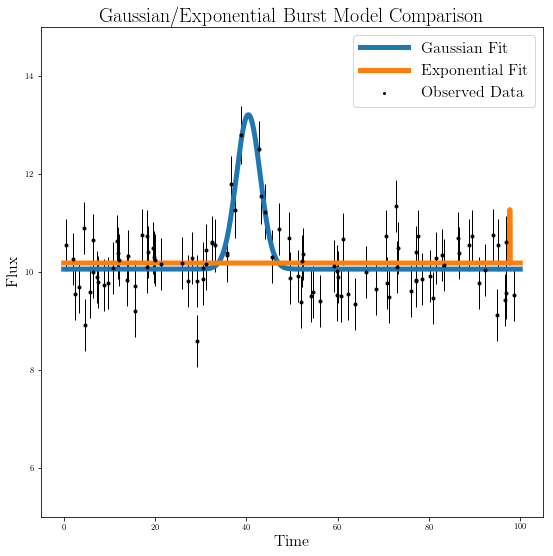

In [63]:
# Run the model comparison MCMC chains
N = 100 # Number of data points to generate

t_obs,y_obs,err_y,\
Gaussian_traces,Gaussian_fit_vals,Gaussian_BF,\
Exponential_traces,Exponential_fit_vals,Exponential_BF\
= Run_Gaussian_Exponential_Comparison(N)

Plot_Gaussian_Exponential_Comparison(t_obs,y_obs,err_y,
                                     Gaussian_traces,Gaussian_fit_vals,
                                     Exponential_traces,Exponential_fit_vals)

print('\nBayes Factor = %f' %(Gaussian_BF/Exponential_BF))

We are not quite sure what to make of this Bayes Factor that we got from AstroML.

# Problem 2
### Plot the data and best-fit models for N=100 Points

 [-----------------100%-----------------] 25000 of 25000 complete in 4.1 sec
================ Model BIC Information ===============
For N=100 Data Points:
BIC for Gaussian Profile: 100.5
BIC for Exponential Profile: 159.0


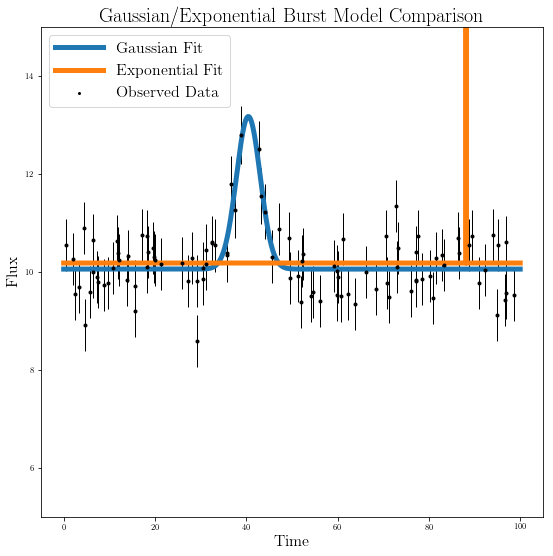

In [19]:
# Run the model comparison MCMC chains
N = 100 # Number of data points to generate

t_obs,y_obs,err_y,\
Gaussian_traces,Gaussian_fit_vals,Gaussian_BF,\
Exponential_traces,Exponential_fit_vals,Exponential_BF\
= Run_Gaussian_Exponential_Comparison(N)

Plot_Gaussian_Exponential_Comparison(t_obs,y_obs,err_y,
                                     Gaussian_traces,Gaussian_fit_vals,
                                     Exponential_traces,Exponential_fit_vals)

# Print the BIC for each model
y_Gauss_fit = GaussAndBkgd(t_obs,*Gaussian_fit_vals)
y_Exp_fit = burst(t_obs,*Exponential_fit_vals)
Gauss_ChiSq = np.sum(((y_obs-y_Gauss_fit)/err_y)**2)
Exp_ChiSq = np.sum(((y_obs-y_Exp_fit)/err_y)**2)

Print_BIC(Gauss_ChiSq,Exp_ChiSq,N)

We can see from the BIC of each model that the Gaussian Profile fits better.

# Problem 3
### Plot the data and best-fit models for N=200 Points


 [-----------------100%-----------------] 25000 of 25000 complete in 5.0 sec
================ Model BIC Information ===============
For N=200 Data Points:
BIC for Gaussian Profile: 209.7
BIC for Exponential Profile: 257.4


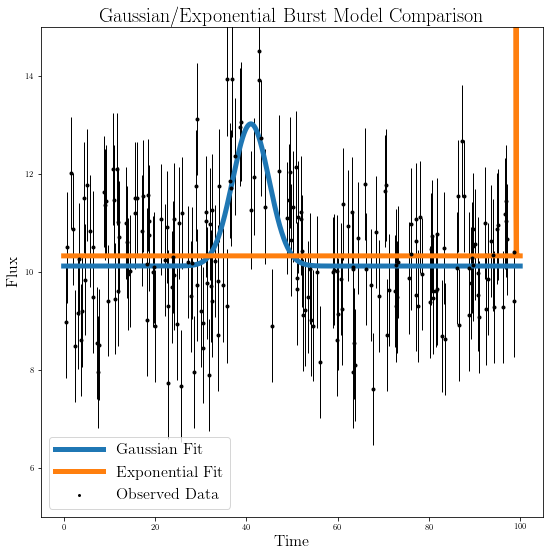

In [25]:
# Run the model comparison MCMC chains
N = 200 # Number of data points to generate

t_obs,y_obs,err_y,\
Gaussian_traces,Gaussian_fit_vals,Gaussian_BF,\
Exponential_traces,Exponential_fit_vals,Exponential_BF,\
= Run_Gaussian_Exponential_Comparison(N)

Plot_Gaussian_Exponential_Comparison(t_obs,y_obs,err_y,
                                     Gaussian_traces,Gaussian_fit_vals,
                                     Exponential_traces,Exponential_fit_vals)

# Print the BIC for each model
y_Gauss_fit = GaussAndBkgd(t_obs,*Gaussian_fit_vals)
y_Exp_fit = burst(t_obs,*Exponential_fit_vals)
Gauss_ChiSq = np.sum(((y_obs-y_Gauss_fit)/err_y)**2)
Exp_ChiSq = np.sum(((y_obs-y_Exp_fit)/err_y)**2)

Print_BIC(Gauss_ChiSq,Exp_ChiSq,N)

With 200 points, we can still use the BIC to see that the Gaussian Profile is better

# Problem 4
### Plot the data and best-fit models for N=50 Points


 [-----------------100%-----------------] 25000 of 25000 complete in 5.2 sec
================ Model BIC Information ===============
For N=50 Data Points:
BIC for Gaussian Profile: 64.4
BIC for Exponential Profile: 52.9


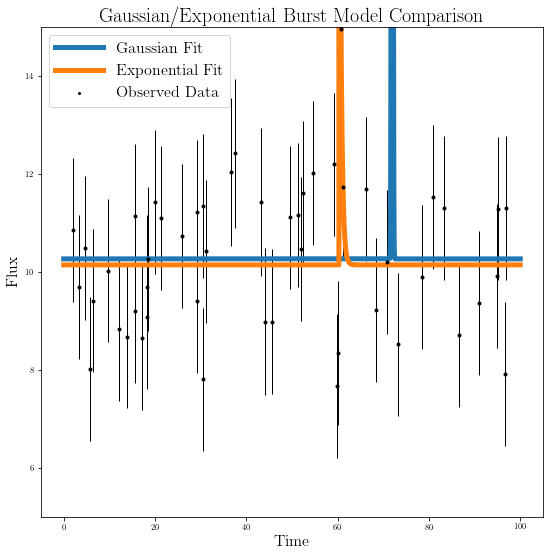

In [9]:
# Run the model comparison MCMC chains
N = 50 # Number of data points to generate

t_obs,y_obs,err_y,\
Gaussian_traces,Gaussian_fit_vals,Gaussian_BF,\
Exponential_traces,Exponential_fit_vals,Exponential_BF,\
= Run_Gaussian_Exponential_Comparison(N)

Plot_Gaussian_Exponential_Comparison(t_obs,y_obs,err_y,
                                     Gaussian_traces,Gaussian_fit_vals,
                                     Exponential_traces,Exponential_fit_vals)

# Print the BIC for each model
y_Gauss_fit = GaussAndBkgd(t_obs,*Gaussian_fit_vals)
y_Exp_fit = burst(t_obs,*Exponential_fit_vals)
Gauss_ChiSq = np.sum(((y_obs-y_Gauss_fit)/err_y)**2)
Exp_ChiSq = np.sum(((y_obs-y_Exp_fit)/err_y)**2)

Print_BIC(Gauss_ChiSq,Exp_ChiSq,N)

With only 50 points, however, we cannot tell which model is better based on the BIC

# BONUS ROUND
Run over a range of N and compare the BIC and Odds Ratio values as a function of N

In [26]:
N_Array = [50,75,100,150,200,400,600,800,1000]
Gauss_ChiSq = np.ones(np.size(N_Array))
Exp_ChiSq = np.ones(np.size(N_Array))
Odds_Ratio = np.ones(np.size(N_Array))

for i,N in enumerate(N_Array):
    if (i != 0):
        print('\n')
    print('Running Model Comparison for N=%i Data Points' %N)
    t_obs,y_obs,err_y,\
    Gaussian_traces,Gaussian_fit_vals,Gaussian_BF,\
    Exponential_traces,Exponential_fit_vals,Exponential_BF,\
    = Run_Gaussian_Exponential_Comparison(N)
    
    y_Gauss_fit = GaussAndBkgd(t_obs,*Gaussian_fit_vals)
    y_Exp_fit = burst(t_obs,*Exponential_fit_vals)
    Gauss_ChiSq[i] = np.sum(((y_obs-y_Gauss_fit)/err_y)**2)
    Exp_ChiSq[i] = np.sum(((y_obs-y_Exp_fit)/err_y)**2)
    Odds_Ratio[i] = Gaussian_BF/Exponential_BF

Running Model Comparison for N=50 Data Points
 [-----------------100%-----------------] 25000 of 25000 complete in 4.0 sec

Running Model Comparison for N=75 Data Points
 [-----------------100%-----------------] 25000 of 25000 complete in 4.5 sec

Running Model Comparison for N=100 Data Points
 [-----------------100%-----------------] 25000 of 25000 complete in 4.1 sec

Running Model Comparison for N=150 Data Points
 [-----------------100%-----------------] 25000 of 25000 complete in 4.7 sec

Running Model Comparison for N=200 Data Points
 [-----------------100%-----------------] 25000 of 25000 complete in 4.4 sec

Running Model Comparison for N=400 Data Points
 [-----------------100%-----------------] 25000 of 25000 complete in 5.2 sec

Running Model Comparison for N=600 Data Points
 [-----------------100%-----------------] 25000 of 25000 complete in 6.5 sec

Running Model Comparison for N=800 Data Points
 [-----------------100%-----------------] 25000 of 25000 complete in 8.1 sec

Ru

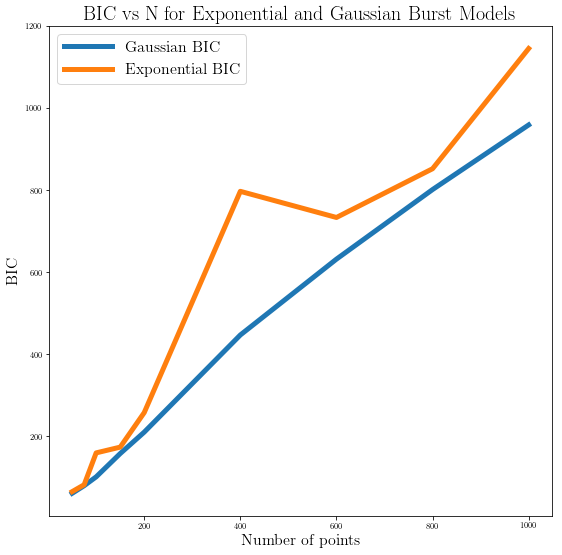

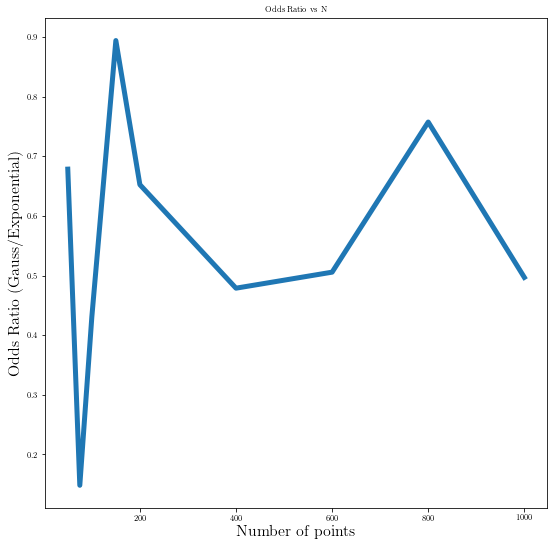

In [27]:
Gauss_BIC = Gauss_ChiSq + 4*np.log(N_Array)
Exp_BIC = Exp_ChiSq + 4*np.log(N_Array)

plt.figure(figsize=[9,9])
plt.plot(N_Array,Gauss_BIC,lw=5)
plt.plot(N_Array,Exp_BIC,lw=5)
plt.xlabel('Number of points',fontsize=16)
plt.ylabel('BIC',fontsize=16)
plt.title('BIC vs N for Exponential and Gaussian Burst Models',fontsize=20)
plt.legend(['Gaussian BIC','Exponential BIC'],fontsize=16)

plt.figure(figsize=[9,9])
plt.plot(N_Array,Odds_Ratio,lw=5)
plt.xlabel('Number of points',fontsize=16)
plt.ylabel('Odds Ratio (Gauss/Exponential)',fontsize=16)
plt.title('Odds Ratio vs N')

We can see from the above plot that, except at very low values of N, the BIC of the Gaussian Model is lower than that of the Exponential Model.